In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


2024-11-04 00:16:39.897317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Step 1: Load the electricity consumption dataset
def load_electricity_data(location):
    loc = location
    df = pd.read_csv(loc, sep=';', parse_dates={'datetime': ['Date', 'Time']}, 
                     infer_datetime_format=True, 
                     low_memory=False, na_values=['nan','?'])
    
    # Keep relevant columns and drop missing values
    df = df[['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].dropna()
    
    # Set the datetime as the index
    df.set_index('datetime', inplace=True)
    return df

# Load dataset
df = load_electricity_data('household_power_consumption.txt')

/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_22579/1271559721.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(loc, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_22579/1271559721.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(loc, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_22579/1271559721.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  

In [15]:
# Step 2: Convert the data into a usable format
# Convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Resample to hourly frequency and fill missing values
df = df.resample('H').mean().fillna(method='ffill')

/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_22579/610273611.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean().fillna(method='ffill')
/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_22579/610273611.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('H').mean().fillna(method='ffill')


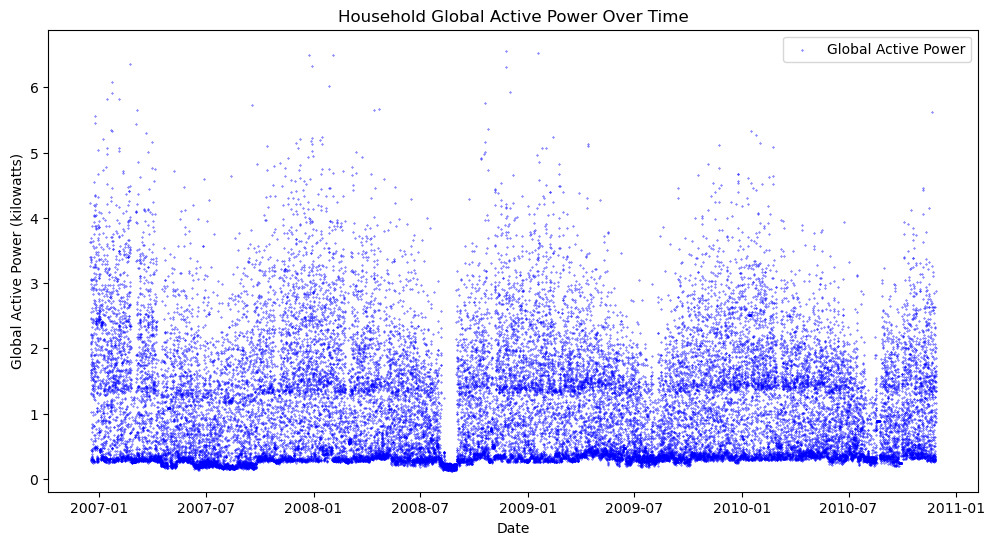

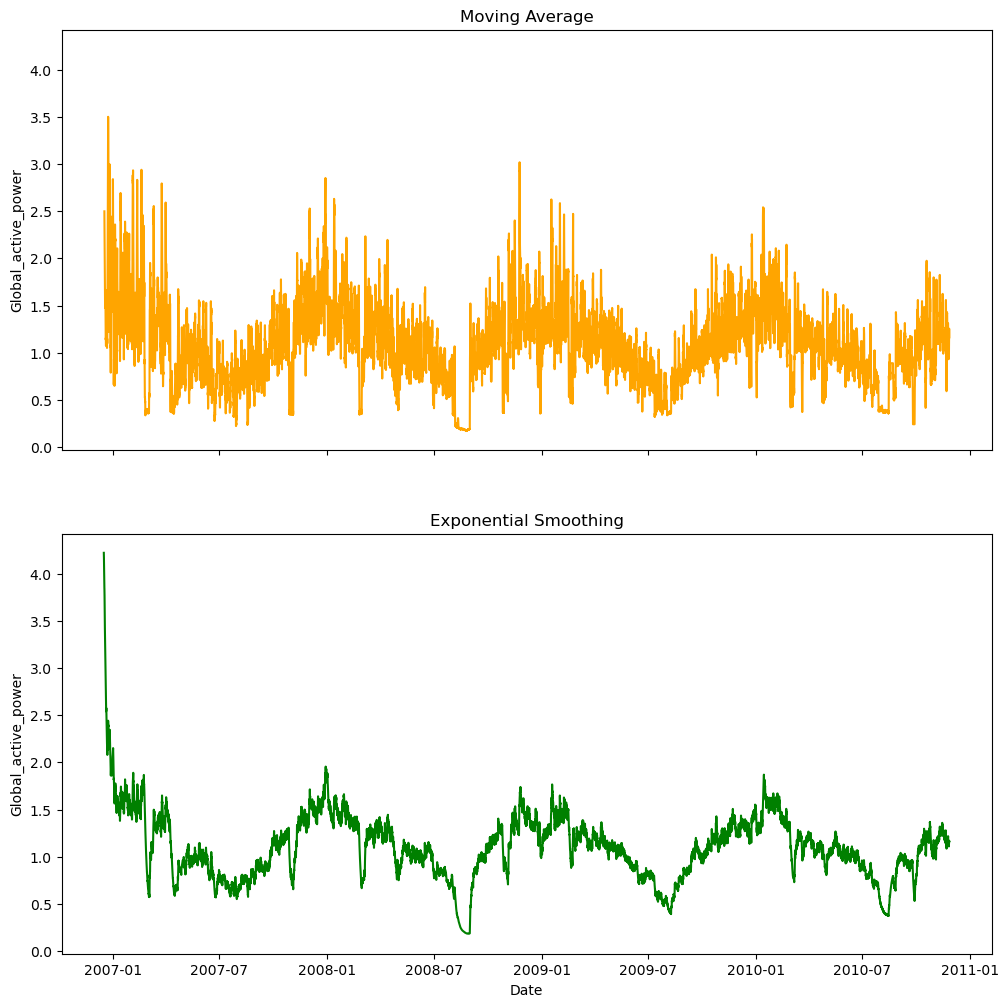

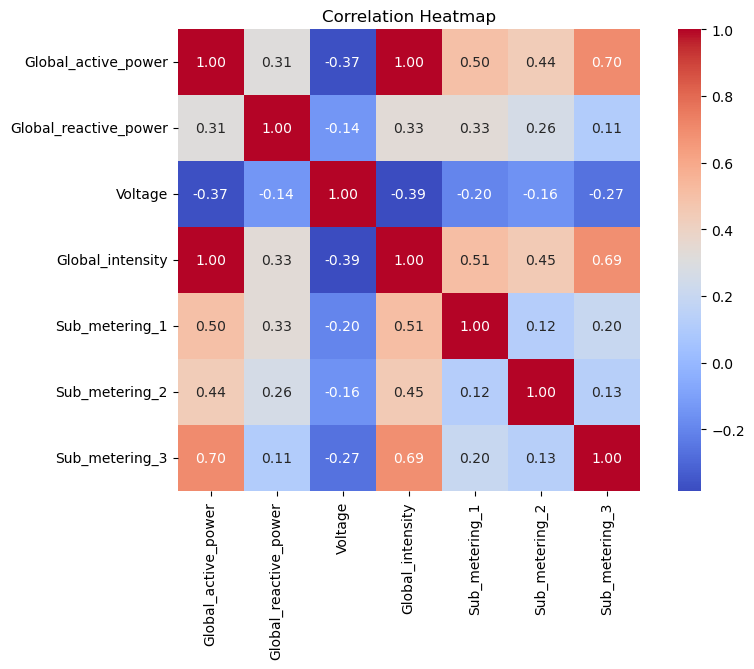

In [16]:
# Step 3: Perform Exploratory Data Analysis (EDA)

# Scatter plot showing the seasonal pattern
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Global_active_power'], label='Global Active Power', color='blue', s=0.1)
plt.title('Household Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()


# Smoothening the data to see seasonal patters.
# Function for moving average smoothing
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Function for exponential smoothing
def exponential_smoothing(data, alpha):
    return data.ewm(alpha=alpha, adjust=False).mean()

# Play around with index ranges and smoothening parameters to see differrent seasonal patterns
test_df = df.copy().iloc[:,:]
test_df = test_df.drop(['Global_reactive_power', 'Voltage', 
             'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis=1)

# Smooth the data using different methods
window_size = 24  # For moving average
alpha = 0.01      # For exponential smoothing

test_df['moving_avg'] = moving_average(test_df['Global_active_power'], window_size)
test_df['exp_smooth'] = exponential_smoothing(test_df['Global_active_power'], alpha)

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,  sharey=True, figsize=(12,12))
plt.xlabel('Date')
ax1.plot(test_df.index, test_df['moving_avg'], label='Moving Average', color='orange')
ax1.set_ylabel('Global_active_power')
ax1.set_title('Moving Average')
ax2.plot(test_df.index, test_df['exp_smooth'], label='Exponential Smoothing', color='green')
ax2.set_ylabel('Global_active_power')
ax2.set_title('Exponential Smoothing')
plt.show()


# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
# Normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Global_active_power']])

# Step 4: Prepare the data for modeling
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Hyperparameter: number of time steps
time_step = 48  # Specify the past # of hours to predict the next hour
X, y = create_dataset(scaled_data, time_step)

# Reshape input for RNN: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(27632, 48, 1)

In [20]:
# Step 5: Function to create models
def create_model(model_type='RNN', units=50, dropout_rate=0.2):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(X_train.shape[1], 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for regression
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [21]:
# Hyperparameters to tune
units = 50  # Number of units in the RNN layers
dropout_rate = 0.2  # Dropout rate

# Model types to compare
model_types = ['RNN', 'GRU', 'LSTM']
results = {}
loss_histories = {}

# Step 6: Train and evaluate each model
for model_type in model_types:
    print("----------------------- Started {} model training -----------------------".format(model_type))
    model = create_model(model_type=model_type, units=units, dropout_rate=dropout_rate)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)      #, callbacks=[early_stopping]
    # Storing loss history.
    loss_histories[model_type] = history.history['loss']

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results[model_type] = test_loss

# Print results
for model_type, loss in results.items():
    print(f"{model_type} Test Loss: {loss:.4f}")


----------------------- Started RNN model training -----------------------
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


691/691 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0201 - val_loss: 0.0085
Epoch 2/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 3/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 4/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 5/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 6/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 7/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 8/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 9/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 11/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 12/50
691/691 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.

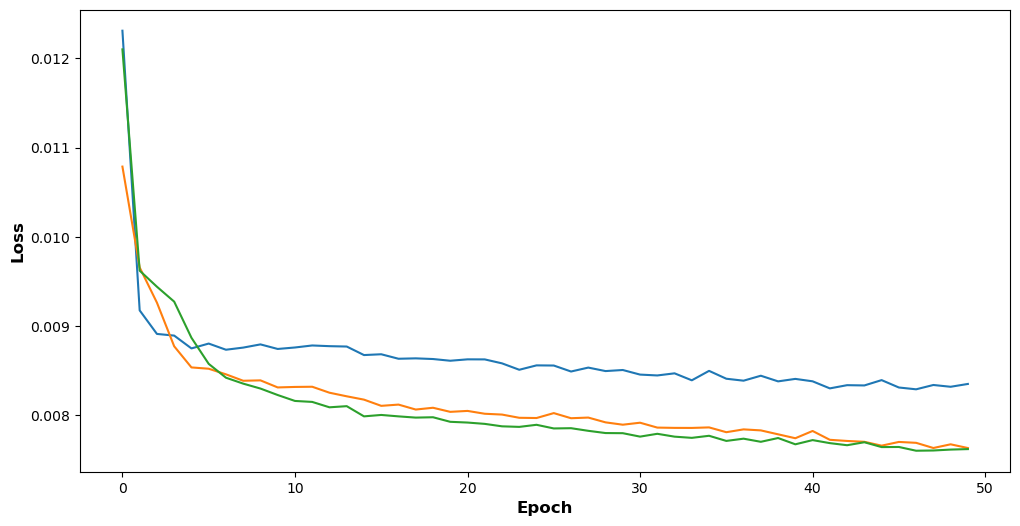

In [45]:
# Step 7: Plot the change in loss function with each epoch for all methods
plt.figure(figsize=(12, 6))
for model_type in model_types:
    plt.plot(loss_histories[model_type], label=f'{model_type} Train Loss')
# plt.title('Training Loss RNN, GRU, and LSTM', fontsize=15)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
# plt.legend()
plt.savefig('comparison.png', transparent=True)
plt.show()